In [2]:
import numpy as np
from pathlib import Path
import tensorflow as tf
from keras.layers import Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Flatten, Dropout
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Rescaling
import matplotlib.pyplot as plt
from PIL import Image

# Download Dataset
---

In [3]:

import os
import subprocess
import zipfile

DS_DESTINATION="media/TP1-3-natural-scenes.zip"
DS_UNZIP_DEST=DS_DESTINATION.replace(".zip","")
DS_DRIVE_ID="1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ"

if not os.path.isfile(DS_DESTINATION):
    print(subprocess.run(["gdown", DS_DRIVE_ID, "-O", DS_DESTINATION], 
                        capture_output=True))
    with zipfile.ZipFile(DS_DESTINATION, 'r') as zip_ref:
        zip_ref.extractall(DS_UNZIP_DEST)

In [12]:
# Directorio de los datos
TRAIN_DIRECTORY = Path("media/TP1-3-natural-scenes/seg_train/seg_train/")
TEST_DIRECTORY = Path("media/TP1-3-natural-scenes/seg_test/seg_test/")
# Tamaño del lote (batch size)
BATCH_SIZE = 64
# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150


# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIRECTORY,
    #validation_split=0.2,
    #subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
    )

val_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIRECTORY,
    #validation_split=0.2,
    #subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
    )

# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
class_lens = {}
val_lens = {}

for c in class_names:
    train_dir = TRAIN_DIRECTORY.joinpath(c)
    val_dir = TEST_DIRECTORY.joinpath(c)
    class_lens[c] = len([name for name in os.listdir(train_dir)])
    val_lens[c] = len([name for name in os.listdir(val_dir)])

print(f"Train: {class_lens}")
print(f"Test:{class_lens}")



Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Train: {'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}
Test:{'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}


tf.Tensor([0. 0. 0. 1. 0. 0.], shape=(6,), dtype=float32)
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([0. 1. 0. 0. 0. 0.], shape=(6,), dtype=float32)
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([0. 1. 0. 0. 0. 0.], shape=(6,), dtype=float32)
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([0. 1. 0. 0. 0. 0.], shape=(6,), dtype=float32)
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([0. 0. 0. 0. 1. 0.], shape=(6,), dtype=float32)
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([0. 0. 0. 1. 0. 0.], shape=(6,), dtype=float32)
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([1. 0. 0. 0. 0

2024-04-30 14:19:10.623361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


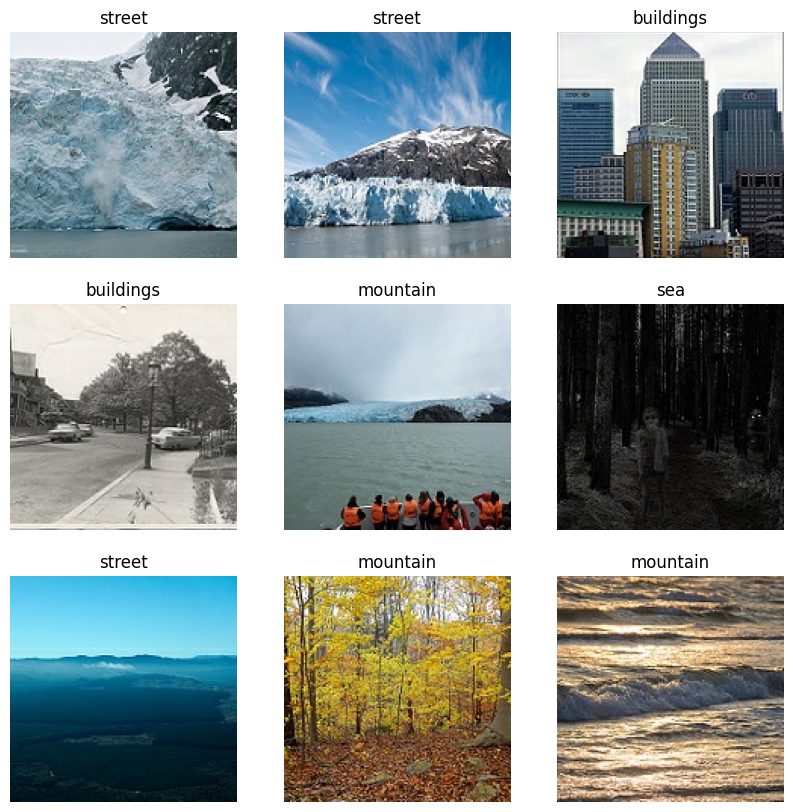

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(5):
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    print(labels[i])
    print(class_names)
    plt.title(class_names[class_idx])
    plt.axis("off")

In [14]:
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(8, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

In [15]:
print("Building model")
model = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


In [16]:
EPOCHS = 5
# Entrena el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 37s 208ms/step - accuracy: 0.1769 - loss: 1.7963 - val_accuracy: 0.1633 - val_loss: 1.7913
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 37s 209ms/step - accuracy: 0.1745 - loss: 1.7914 - val_accuracy: 0.1633 - val_loss: 1.7907
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 37s 212ms/step - accuracy: 0.1777 - loss: 1.7908 - val_accuracy: 0.1633 - val_loss: 1.7913
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 37s 210ms/step - accuracy: 0.1783 - loss: 1.7909 - val_accuracy: 0.1633 - val_loss: 1.7911
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 37s 213ms/step - accuracy: 0.1785 - loss: 1.7908 - val_accuracy: 0.1633 - val_loss: 1.7910
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 37s 209ms/step - accuracy: 0.1785 - loss: 1.7907 - val_accuracy: 0.1633 - val_loss: 1.7910
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 37s 208ms/step - accuracy: 0.1785 - loss: 1.7907 - val_accuracy: 0.1633 - val_loss: 1.7910
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 37s 208ms/step - accuracy: 0.1785 - loss: 1

KeyboardInterrupt: 

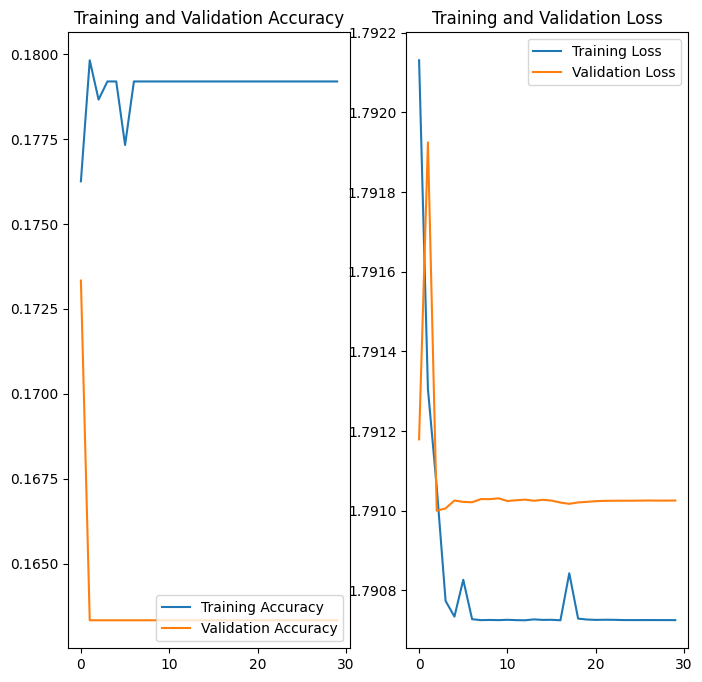

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
[[0.15535296 0.16007859 0.1723222  0.17948958 0.16220888 0.17054777]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.15535296 0.16007859 0.1723222  0.17948958 0.16220888 0.17054777]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[0.15535296 0.16007859 0.1723222  0.17948958 0.16220888 0.17054777]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.15535296 0.16007859 0.1723222  0.17948958 0.16220888 0.17054777]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[0.15535296 0.16007859 0.1723222  0.17948958 0.16220888 0.17054777]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[0.15535296 0.16007859 0.1723222  0.17948958 0.16220888 0.17054777]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[0.15535296 0.16007859 0.1723222  0.17948958 0.16220888 0.17054777]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.15535296 0.16007859 0.1723222  0.17948958 0.16220888 0.17054777]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.15535296 0.16007859 0.1723222  0.17948958 0.16220888 0.17054777]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

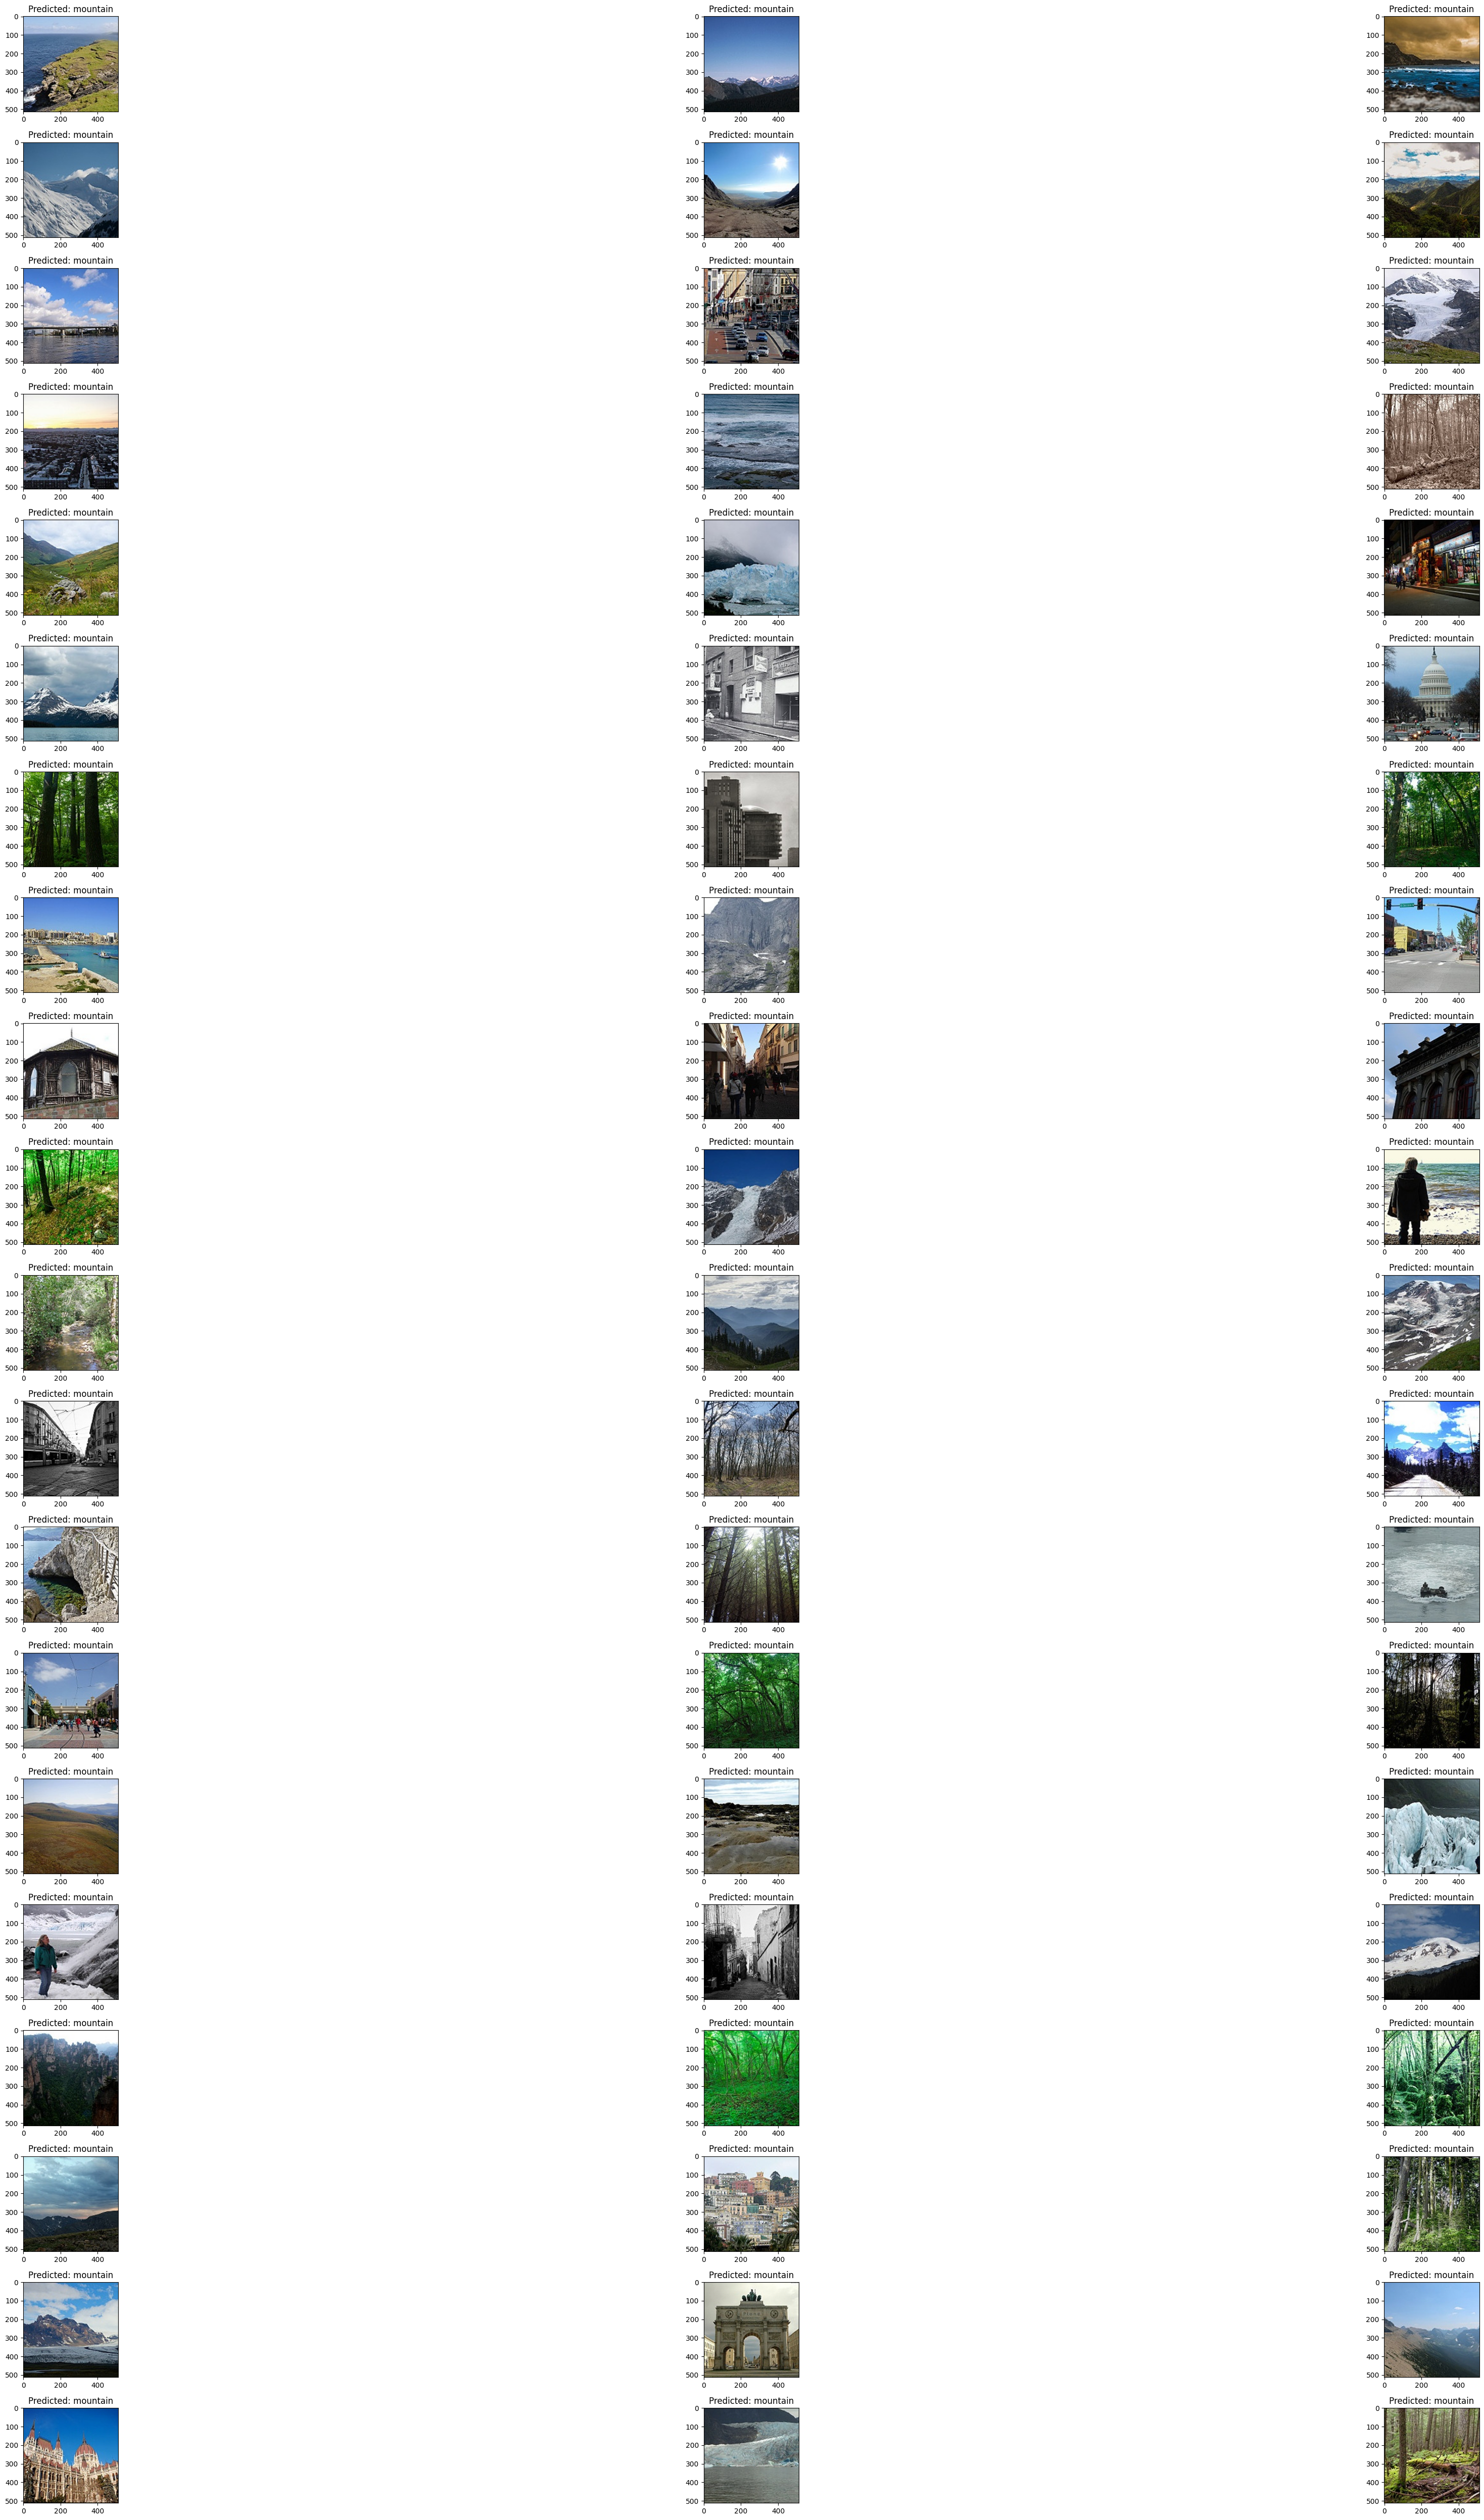

In [ ]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Test images directory
TEST_IMAGES_DIRECTORY = Path("media/TP1-3-natural-scenes/seg_pred/seg_pred/")

# Get list of test image paths
test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*.jpg"))

# Display 5 images with their actual and predicted classes
sx=20
sy=3
fig, axs = plt.subplots(sx, sy, figsize=(50, 50))

i = 0
for x in range(0, sx):
    for y in range(0,sy):

        image_path = test_image_paths[i]
        image = preprocess_image(image_path)
        image_show = preprocess_image(image_path,(512,512))
        axs[x][y].imshow(image_show)
        image = np.expand_dims(image, axis=0)  # Add batch dimension

        # Perform prediction
        prediction = model.predict(image)
        print(prediction)
        predicted_class_index = np.argmax(prediction)
        predicted_class = class_names[predicted_class_index]        

        axs[x][y].set_title(f"Predicted: {predicted_class}")
        i+=1

plt.tight_layout()
plt.show()